In [1]:
import numpy as np
from plind import PLModel
from plind.contour_dict import real_contour_1d
from plind.contour_dict import real_contour_nd
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 1D Rational Lens

This example shows the evaluation of the diffraction integral for a lens with potential $S(x; y, \nu, \alpha) =\nu [ (x-y)^2 + \frac{\alpha}{1+x^2} ]$. The Morse function is $h(z) = \mathrm{Re} iS(z)$ and the gradient of the Morse function is given by $\frac{dh}{dz} = 2 i [ z - y  - \frac{z \alpha}{(1+z^2)^2}]^*$ where $*$ indicated the complex conjugate.

In [2]:
# Define the integrand and the Morse gradient
def rat_expfun(x, y, alpha, nu):
    return 1j*nu*((x-y)**2 + (alpha/(1+x*x)) )

def rat_grad(x, y, alpha, nu):
    return 1j*np.conj(2*((x-y) - (x*alpha/(1+x*x)**2)))

In [3]:
# Set Lens Parameters
alpha = 2
nu = 10
y = 0

# Set plind parameters
delta = 0.1  # minimum grid spacing
thresh = -100  # minimum value of the log of the Morse function points can attain before being discarded
domain = [-2, 2]  # bounds of the initial integration domain on the real line
Ninit = 100  # number of points for grid on the initial domain
dt_init = 8e-3  # initial timestep for the ODE solver
tmax = 8e-1  # maximum integration time for ODE solver

In [4]:
# Initialize initial intergation contour on the real axis
init_contour = real_contour_1d(Ninit, domain)

# Initialize PLModel object
pmod = PLModel(init_contour, rat_expfun, rat_grad, expargs=[y, alpha, nu])

# Flow contour to Lefschetz thimbles
pmod.descend(delta, thresh, tmax, dt_init, verbose=True)

# Integrate
pmod.integrate()
print("Integral = ", pmod.integral[0], "\n",
      "Estimate of error magnitude =", pmod.integral[1])

total steps: 136 current time: 0.8000370008154654
Integral =  (1.4922827573344952+0.4091753956844676j) 
 Estimate of error magnitude = 1.35553261020198e-10


/home/fx/plind/src/plind/descend/core.py:34: RuntimeWarning: divide by zero encountered in divide
  delta = np.min((np.divide(tol, 2*R))**(1/4))


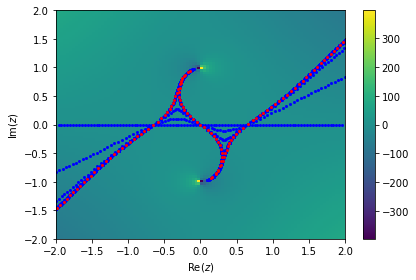

In [5]:
# Plot the Lefschetz thimbles
u, v = np.meshgrid(np.linspace(domain[0], domain[1], 100), np.linspace(domain[0], domain[1], 100), indexing='ij')
z = u + 1j*v

fig, ax = plt.subplots()
ax.set_xlabel("Re($z$)")
ax.set_ylabel("Im($z$)")
ax.set_ylim(domain[0], domain[1])
ax.set_xlim(domain[0], domain[1])
# Plot h
im = ax.pcolormesh(u, v, np.real(rat_expfun(z, y, alpha, nu)))
fig.colorbar(im, ax=ax)

# Plot progress towards Lefschetz thimble in blue
for k in np.linspace(0, pmod.trajectory.shape[0], pmod.trajectory.shape[0]//4, endpoint=False):
    k = int(k)
    ax.scatter(pmod.trajectory[k].points.real[1:-1].flatten(), pmod.trajectory[k].points.imag[1:-1].flatten(), s=4, c='b')
    
#Plot final contour in red
ax.scatter(pmod.contour.points.real[1:-1].flatten(), pmod.contour.points.imag[1:-1].flatten(), s=4, c='r')
ax.set_rasterization_zorder(-10)
plt.tight_layout()
plt.show()

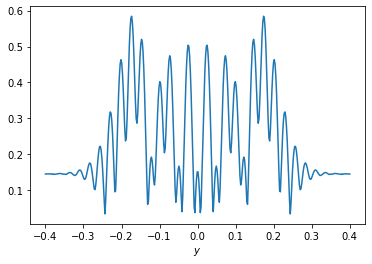

In [6]:
# Compute integral for multiple values of y
alpha = 2
nu = 100

Ys = np.linspace(-0.4, 0.4, 400)

INTVALS = []
for y in Ys:
    init_contour = real_contour_1d(100, [-1,1])
    pmod = PLModel(init_contour, rat_expfun, rat_grad, expargs=[y, alpha, nu])
    pmod.descend(0.1, -10, 8e-1, 8e-3, verbose=False)
    pmod.integrate()
    INTVALS.append(np.abs(pmod.integral[0]))
    
fig, ax = plt.subplots()
ax.set_xlabel('$y$')
ax.plot(Ys, INTVALS)
plt.show()


# 2D and 3D Gaussian

Here we compute the nD Gaussian integral, $S(\vec{x}) = \vec{x}^2$. This has a known value of $(i \pi)^{n/2}$.

In [7]:
# define integral and gradient
def Gauss_exp(z, ndim):
    gauss_sum=0
    if (ndim ==1):
        gauss_sum=z**2
    else: 
        for i in range(ndim):
            gauss_sum= gauss_sum + z[i]**2
    return 1j*(gauss_sum)

def Gauss_grad(z, ndim):
    return 2*1j*np.conj(z)

def Gauss_answer(ndim):
    return (np.pi*1j)**(ndim/2)

In [8]:
# 2D Gaussian
ndim = 2

# pmod parameters
delta = 0.4
thresh = -50
domain = [-0.5, 0.5, -0.5, 0.5]
Ninit = 10  # for 2D this creates a Ninit x Ninit grid over the domain
dt_init = 8e-3  
tmax = 2

# Initialize
init_contour = real_contour_nd(Ninit, domain)
pmod = PLModel(init_contour, Gauss_exp, Gauss_grad, expargs=[ndim])

# Flow and integrate
pmod.descend(delta, thresh, tmax, dt_init)
pmod.integrate()
print("Result:", pmod.integral[0], "\n" 
      "Answer:", Gauss_answer(ndim), "\n" 
      "Difference:", np.abs(pmod.integral[0]-Gauss_answer(ndim)))
      
      

total steps: 23 current time: 2.0046569475091065
Result: (-3.26182223592264e-16+3.1415926535897913j) 
Answer: 3.141592653589793j 
Difference: 1.806056052250771e-15


We can check that the contour has converged to the thimble by plotting the integrand along the final contour. If the imaginary part is roughly constant, we know we have converged.

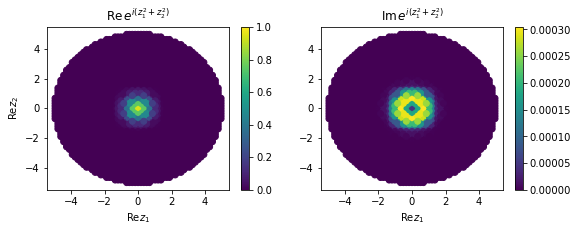

In [9]:
intfun = pmod.get_intfun()
xs = np.real(pmod.contour.points[:,0])
ys = np.real(pmod.contour.points[:,1])


intvals = np.array([intfun(p, *pmod.expargs) for p in pmod.contour.points])

fig, ax = plt.subplots(1,2, figsize=(9,3))
im0 = ax[0].scatter(xs, ys, c=intvals.real)
im1 = ax[1].scatter(xs, ys, c=intvals.imag)
fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

ax[0].set_xlabel('$\mathrm{Re}z_1$')
ax[0].set_ylabel('$\mathrm{Re}z_2$')
ax[1].set_xlabel('$\mathrm{Re}z_1$')
ax[0].set_title('$\mathrm{Re}\,e^{i(z_1^2 + z_2^2)}$')
ax[1].set_title('$\mathrm{Im}\,e^{i(z_1^2 + z_2^2)}$')
plt.show()



We can also compute the 3D Gaussian case, $S(z) = z_1^2 + z_2^2 + z_3^2$.

In [10]:
ndim = 3

# pmodel params
delta = 1
thresh = -30
domain = [-0.5, 0.5, -0.5, 0.5, -0.5, 0.5]
Ninit = 20
dt_init = 0.1
tmax = 2.0

# initialize
init_contour = real_contour_nd(Ninit, domain)
pmod = PLModel(init_contour, Gauss_exp, Gauss_grad, expargs=[ndim])

# descend
pmod.descend(delta, thresh, tmax, dt_init)

# refine grid
pmod.contour.refine_edges(delta/10)   # you can initialize with a sparse grid, flow,
                                        # and then refine once the thimbles are reached

# Integrate
pmod.integrate()
print("Result:", -pmod.integral[0], "\n" 
      "Answer:", Gauss_answer(ndim), "\n" 
      "Difference:", np.abs(pmod.integral[0] + Gauss_answer(ndim)))

total steps: 23 current time: 2.0003172674395895
Result: (-3.936997112926061+3.936996311724511j) 
Answer: (-3.9374024864306048+3.937402486430605j) 
Difference: 0.0005738515226581735


Note this example shows a problem in the code which occurs for dimensions higher than 2D. The simplices that form the integration contour do not have an orientation specified, and in the course of flowing, the orientation can flip causing an overall sign error. We intend to resolve this issue in future

# 2D Rational Lens

This example shows the evaluation of the diffraction integral for a 2D lens with potential $S(\vec{z}; \vec{y}, \nu, \alpha) =\nu [ (\vec{z}-\vec{y})^2 + \frac{\alpha}{1+z_1^2+2 z_2^2} ]$. 

In [11]:
def rat2d_expfun(x, y, alpha, nu):
    return 1j*nu*((x[0]-y[0])**2 + (x[1]-y[1])**2 + (alpha/(1+x[0]*x[0]+2*x[1]*x[1])) )

def rat2d_grad(x, y, alpha, nu):
    return np.array([1j*np.conj(2*((x[0]-y[0]) - (x[0]*alpha/(1+x[0]*x[0]+2*x[1]*x[1])**2))),
                     1j*np.conj(2*((x[1]-y[1]) - (2*x[1]*alpha/(1+x[0]*x[0]+2*x[1]*x[1])**2)))])

In [12]:
# lens paramaters
alpha = 1.3
nu = 10
y = [0., 0.]

# pmod parameters
delta = 0.3
thresh = -50
domain = [-1., 1., -1., 1.]
Ninit = 10
dt_init = 8e-3
tmax = 1

# initialize
init_contour = real_contour_nd(Ninit, domain)
pmod = PLModel(init_contour, rat2d_expfun, rat2d_grad, expargs=[y, alpha, nu])

# descend
pmod.descend(delta, thresh, tmax, dt_init)
pmod.contour.refine_edges(delta/100)
pmod.integrate()
print("Integral = ", pmod.integral[0], "\n",
     "Estimate of error magnitude =", pmod.integral[1])

/home/fx/miniconda3/envs/science/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


total steps: 4053 current time: 1.0001321963630723
Integral =  (1.0729151935288028-0.04447831935713377j) 
 Estimate of error magnitude = 5.5051248575376e-05


/tmp/ipykernel_7921/194655062.py:4: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  simpvals = np.zeros(pmod.contour.simplices.shape[0], dtype=np.complex)


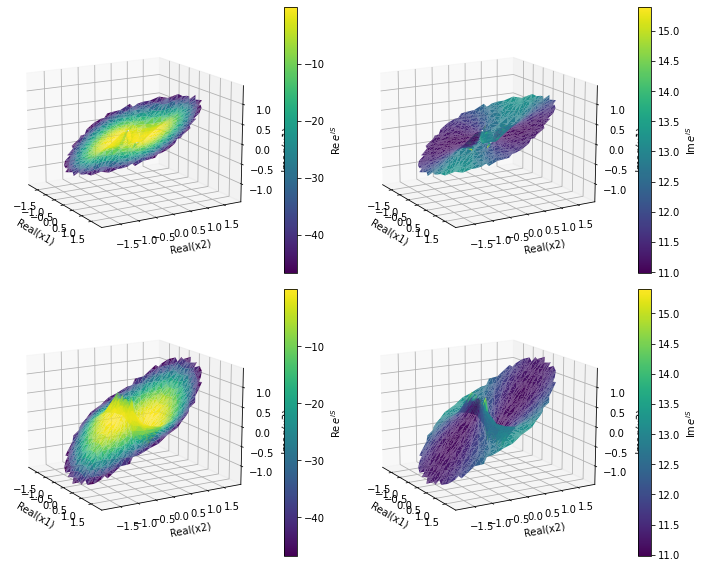

In [13]:
x1 = pmod.contour.points[:,0].real
x2 = pmod.contour.points[:,1].real
intvals = np.array([pmod.intfun(p, *pmod.expargs) for p in pmod.contour.points])
simpvals = np.zeros(pmod.contour.simplices.shape[0], dtype=np.complex)
for j, simp in enumerate(pmod.contour.simplices):
    mid = np.sum(pmod.contour.points[simp], 0)/len(simp)
    simpvals[j] = pmod.expfun(mid, *pmod.expargs)
    
fig = plt.figure(figsize=(10,8))
ax0 = fig.add_subplot(2, 2, 1, projection='3d')
col0 = ax0.plot_trisurf(x1, x2, pmod.contour.points[:,0].imag, triangles=pmod.contour.simplices, cmap=plt.cm.viridis,edgecolors='k',linewidths=0.)
col0.set_array(simpvals.real)
cbar0 = fig.colorbar(col0, pad=0.1, label='$\mathrm{Re}\,e^{iS}$')
ax0.set_zlabel('Imag(x1)')

ax1 = fig.add_subplot(2, 2, 2, projection='3d')
col1 = ax1.plot_trisurf(x1, x2, pmod.contour.points[:,0].imag, triangles=pmod.contour.simplices, cmap=plt.cm.viridis,edgecolors='k',linewidths=0.)
col1.set_array(simpvals.imag)
cbar1 = fig.colorbar(col1, pad=0.1, label='$\mathrm{Im}\,e^{iS}$')
ax1.set_zlabel('Imag(x1)')

ax2 = fig.add_subplot(2, 2, 3, projection='3d')
col2 = ax2.plot_trisurf(x1, x2, pmod.contour.points[:,1].imag, triangles=pmod.contour.simplices, cmap=plt.cm.viridis,edgecolors='k',linewidths=0.)
col2.set_array(simpvals.real)
cbar2 = fig.colorbar(col2, pad=0.1, label='$\mathrm{Re}\,e^{iS}$')
ax2.set_zlabel('Imag(x2)')

ax3 = fig.add_subplot(2, 2, 4, projection='3d')
col3 = ax3.plot_trisurf(x1, x2, pmod.contour.points[:,1].imag, triangles=pmod.contour.simplices, cmap=plt.cm.viridis,edgecolors='k',linewidths=0.)
col3.set_array(simpvals.imag)
cbar3 = fig.colorbar(col3, pad=0.1, label='$\mathrm{Im}\,e^{iS}$')
ax3.set_zlabel('Imag(x2)')

for ax in [ax0, ax1, ax2, ax3]:
    ax.set_xlabel('Real(x1)')
    ax.set_ylabel('Real(x2)')
    ax.view_init(elev=15,azim=-30)

plt.tight_layout()
plt.show()


In [ ]:
# Compute integral for different values of y
alpha = 1.3
nu = 200
Y1, Y2 = np.meshgrid(np.linspace(-0.5, 0.5, 120), np.linspace(-0.4, 0.4, 120))

INTVALS = []
i=0
for y1,y2 in zip(Y1.flatten(), Y2.flatten()):
    clear_output(wait=True)
    y = [y1,y2]
    init_contour = real_contour_nd(100, [-1., 1., -1., 1.])
    pmod = PLModel(init_contour, rat2d_expfun, rat2d_grad, expargs=[y, alpha, nu]) # one can flow with different 
                                                                                   # parameters one integrates with
    pmod.descend(0.05, -10, 1, 8e-3, verbose=True)
    pmod.contour.refine_edges(0.05/100)
    pmod.expargs = [y, alpha, nu]
    pmod.integrate()
    INTVALS.append(pmod.integral[0])
    i += 1
    print('Percent complete:', 100*i/len(Y1.flatten()))
INTVALS = np.array(INTVALS).reshape(Y1.shape)

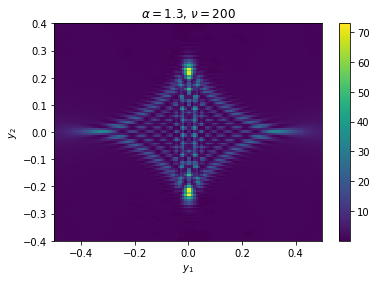

In [31]:
fig, ax = plt.subplots()
im = ax.pcolormesh(Y1, Y2, np.abs((nu/np.pi)*INTVALS)**2)
fig.colorbar(im, ax=ax)
ax.set_xlabel('$y_1$')
ax.set_ylabel('$y_2$')
ax.set_title('$\\alpha=${}, $\\nu=${}'.format(alpha, nu))
plt.show()